# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

/opt/hostedtoolcache/Python/3.10.17/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


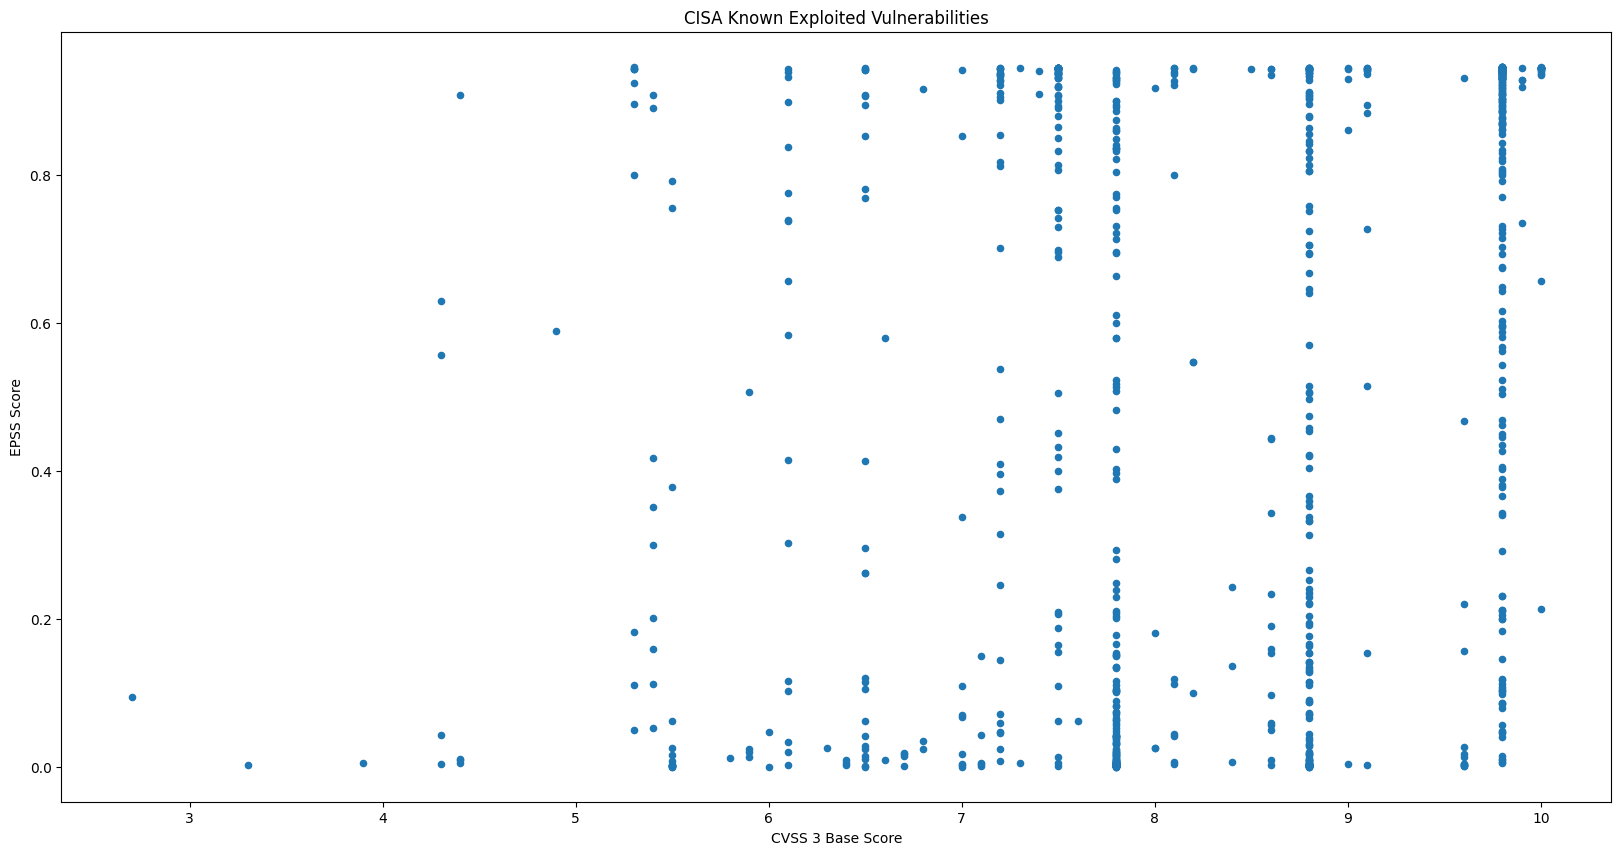

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2025-34028,NaN,0.43622,0.97328,Commvault Command Center contains a path trave...,2025-05-02
1,CVE-2024-58136,9.8,0.36603,0.96884,Yii Framework contains an improper protection ...,2025-05-02
2,CVE-2024-38475,NaN,0.92935,0.99756,Apache HTTP Server contains an improper escapi...,2025-05-01
3,CVE-2023-44221,7.2,0.39496,0.97082,SonicWall SMA100 appliances contain an OS comm...,2025-05-01
4,CVE-2025-31324,9.8,0.54280,0.97840,SAP NetWeaver Visual Composer Metadata Uploade...,2025-04-29
5,CVE-2025-1976,6.7,0.01701,0.81278,Broadcom Brocade Fabric OS contains a code inj...,2025-04-28
6,CVE-2025-42599,9.8,0.20469,0.95181,Qualitia Active! Mail contains a stack-based b...,2025-04-28
7,CVE-2025-3928,8.8,0.19464,0.95030,Commvault Web Server contains an unspecified v...,2025-04-28
8,CVE-2025-24054,5.4,0.35142,0.96787,Microsoft Windows NTLM contains an external co...,2025-04-17
9,CVE-2025-31201,NaN,0.00353,0.56821,"Apple iOS, iPadOS, macOS, and other Apple prod...",2025-04-17
